## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        new_fname = fname.replace('camera_cal','camera_cal_with_corners')
        cv2.imwrite(new_fname, img)
        #cv2.waitKey(500)
    else:
        print('No corners found for', fname)

#cv2.destroyAllWindows()

No corners found for camera_cal/calibration1.jpg
No corners found for camera_cal/calibration5.jpg
No corners found for camera_cal/calibration4.jpg


## Then I compute the camera calibration and distortion coefficients and undistort chessboard images

In [8]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

def undistort_image(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [9]:
# undistort chessboard images
for fname in images:
    img = cv2.imread(fname)
    undist_img = undistort_image(img, mtx, dist)
    new_fname = fname.replace('camera_cal','camera_cal_undistored_images')
    cv2.imwrite(new_fname, undist_img)

# undistort test images
test_undistort_images = glob.glob('test_images/*.jpg')
for fname in test_undistort_images:
    img = cv2.imread(fname)
    undist_img = undistort_image(img, mtx, dist)
    new_fname = fname.replace('test_images','test_images_undistored')
    cv2.imwrite(new_fname, undist_img)

## Pipeline Methods

In [10]:
def threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)#.astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

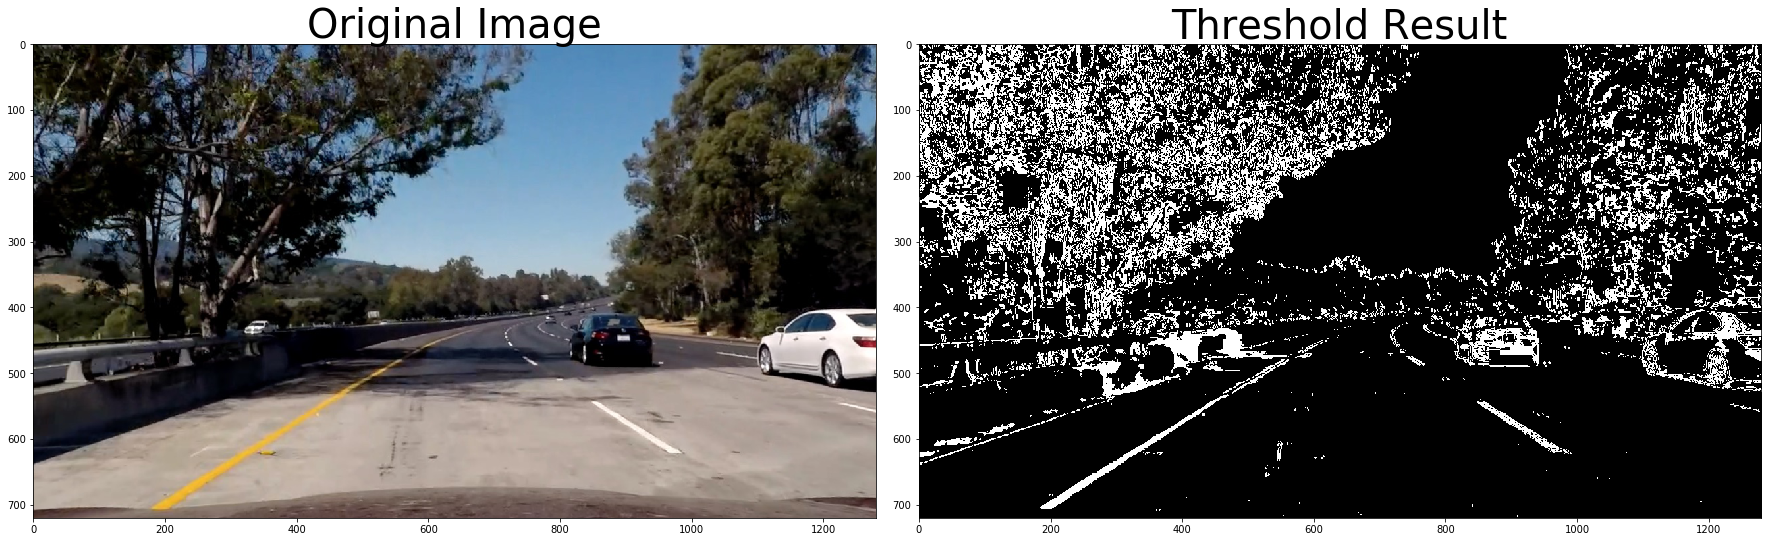

In [11]:
# test pipeline
test_img1 = undistort_image(mpimg.imread('test_images/test5.jpg'), mtx, dist)
result = threshold(test_img1)

# Plot the threshold result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test_img1)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Threshold Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [12]:
def warp_image(undist_img):
    img_size = (undist_img.shape[1], undist_img.shape[0])
    
    # four source points
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
    # four desired points
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist_img, M, img_size, flags=cv2.INTER_LINEAR)

    # Return the resulting image and matrix
    return warped

def unwarp_image(undist_img):
    img_size = (undist_img.shape[1], undist_img.shape[0])
    
    # four source points
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
    # four desired points
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    unwarped = cv2.warpPerspective(undist_img, M, img_size, flags=cv2.INTER_LINEAR)

    # Return the resulting image and matrix
    return unwarped

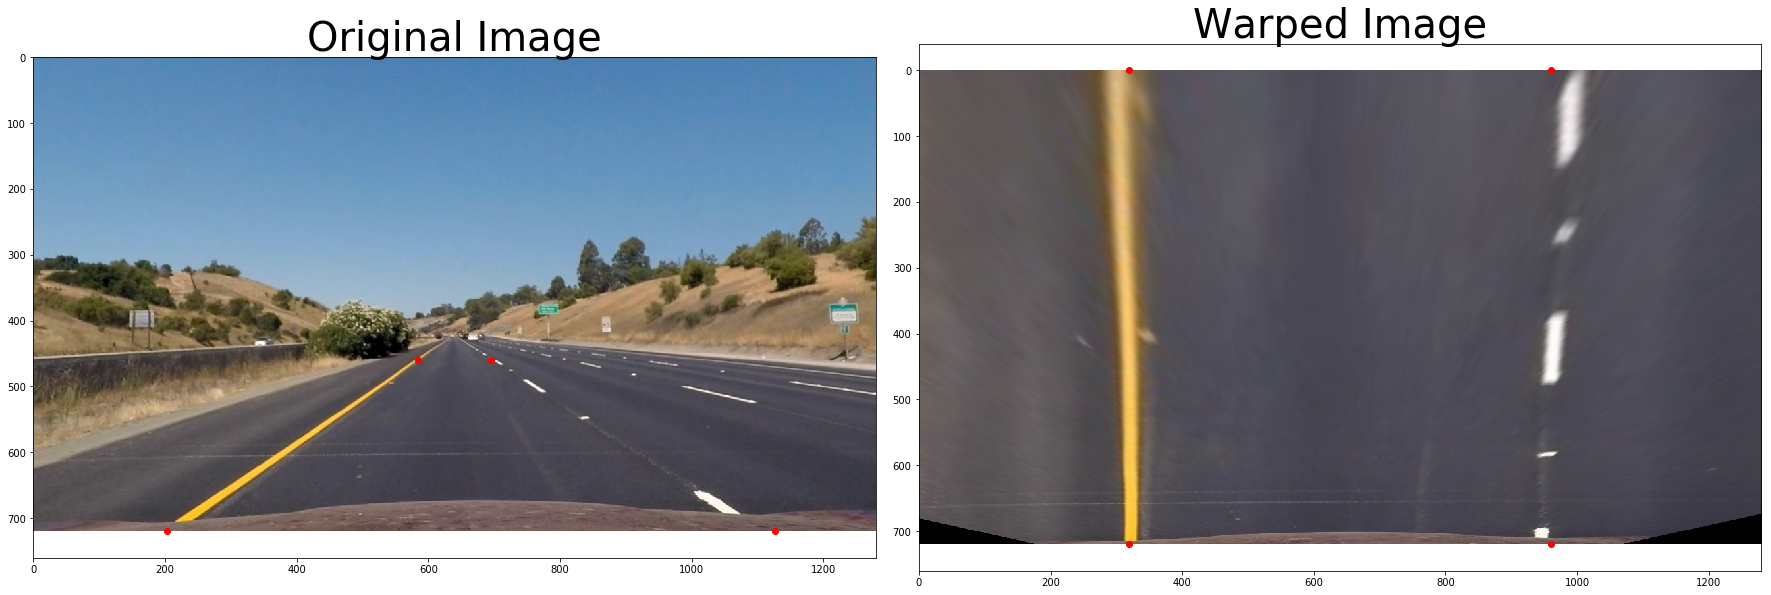

In [15]:
# test perspective transform
img_size = (test_img1.shape[1], test_img1.shape[0])

# four test source points
src = [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]]

# four test desired points
dst =[[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]]

test_img2 = undistort_image(mpimg.imread('test_images/straight_lines1.jpg'), mtx, dist)
img_size = (test_img2.shape[1], test_img2.shape[0])
warped_img1 = warp_image(test_img2)

# Plot the perspective transform result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test_img2)
ax1.scatter(src[0][0], src[0][1], c='r')
ax1.scatter(src[1][0], src[1][1], c='r')
ax1.scatter(src[2][0], src[2][1], c='r')
ax1.scatter(src[3][0], src[3][1], c='r')
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped_img1)
ax2.scatter(dst[0][0], dst[0][1], c='r')
ax2.scatter(dst[1][0], dst[1][1], c='r')
ax2.scatter(dst[2][0], dst[2][1], c='r')
ax2.scatter(dst[3][0], dst[3][1], c='r')
ax2.set_title('Warped Image', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

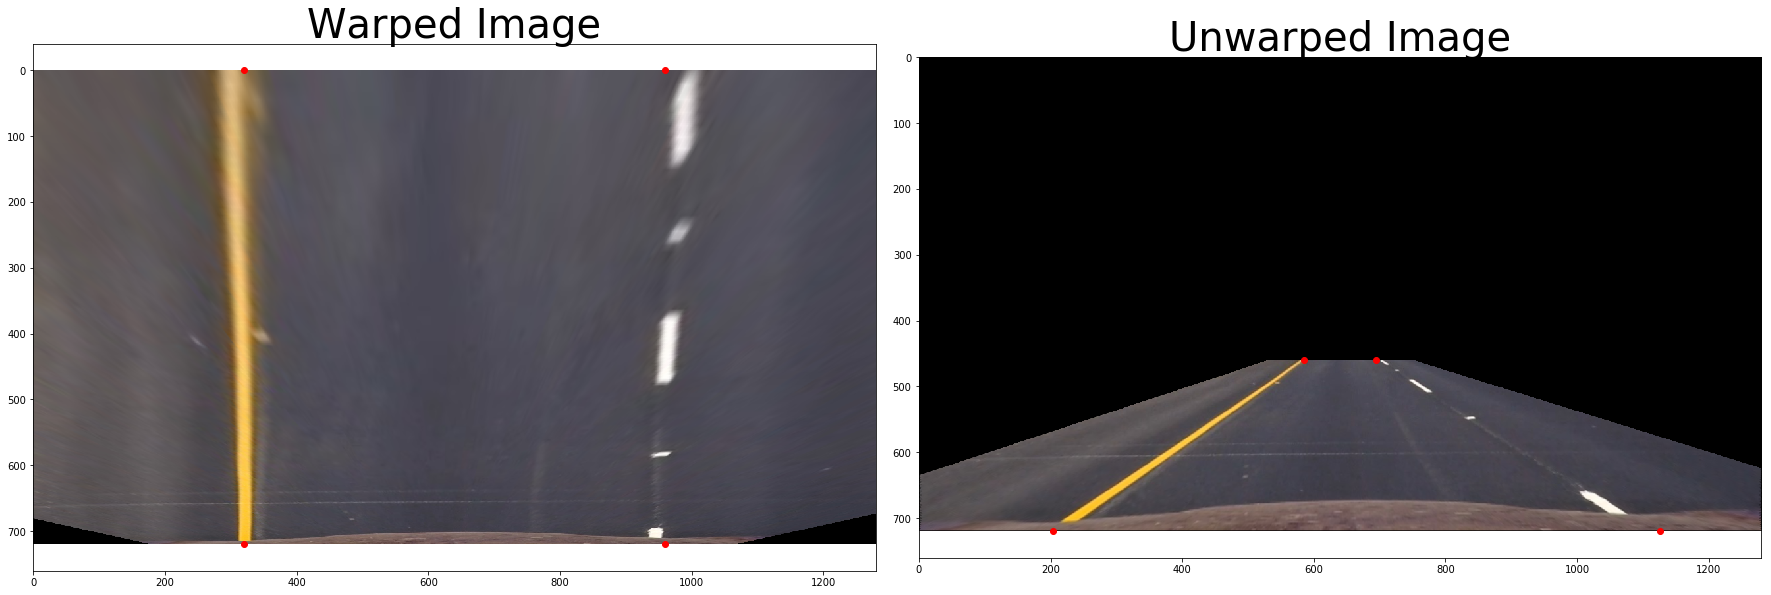

In [16]:
# test unwarp image
unwarped_img = unwarp_image(warped_img1)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped_img1)
ax1.scatter(dst[0][0], dst[0][1], c='r')
ax1.scatter(dst[1][0], dst[1][1], c='r')
ax1.scatter(dst[2][0], dst[2][1], c='r')
ax1.scatter(dst[3][0], dst[3][1], c='r')
ax1.set_title('Warped Image', fontsize=40)

ax2.imshow(unwarped_img)
ax2.scatter(src[0][0], src[0][1], c='r')
ax2.scatter(src[1][0], src[1][1], c='r')
ax2.scatter(src[2][0], src[2][1], c='r')
ax2.scatter(src[3][0], src[3][1], c='r')
ax2.set_title('Unwarped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [17]:
# Identify lane-line pixels and fit their positions with a polynomial
binary_warped = warp_image(threshold(test_img2))
#plt.imshow(thresh_and_warped_img, cmap='gray')

def get_lane_line_info(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty

(720, 0)

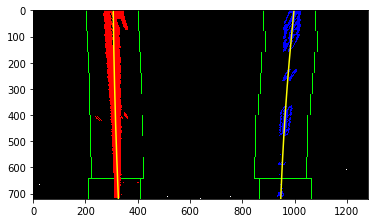

In [18]:
# visualize polyfit of lane lines
left_fit, right_fit, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty = get_lane_line_info(binary_warped)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [19]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

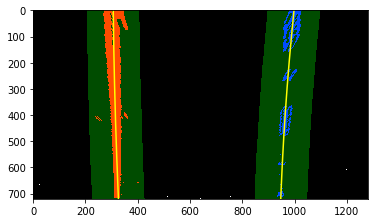

In [20]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

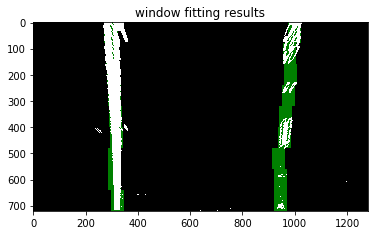

In [21]:
# Sliding Window Search using convolution
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,image.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,image.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

def draw_windows(window_centroids, binary_warped):
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(binary_warped)
    r_points = np.zeros_like(binary_warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,binary_warped,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((binary_warped, binary_warped, binary_warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    return output

window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:
    output = draw_windows(window_centroids, binary_warped)
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()
# test warping the output image
#plt.imshow(unwarp_image(output))


In [27]:
# Test Calculate radius of curvature with fake data
#################### begin fake data
# Generate some fake data to represent lane-line pixels
###ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
###quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
###leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
###                              for y in ploty])
###rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
###                                for y in ploty])

###leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
###rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
###left_fit = np.polyfit(ploty, leftx, 2)
###left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
###right_fit = np.polyfit(ploty, rightx, 2)
###right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
###mark_size = 3
###plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
###plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
###plt.xlim(0, 1280)
###plt.ylim(0, 720)
###plt.plot(left_fitx, ploty, color='green', linewidth=3)
###plt.plot(right_fitx, ploty, color='green', linewidth=3)
###plt.gca().invert_yaxis() # to visualize as we do the images

##################### end fake data

# Calculate radius of curvature with real data

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
y_eval = np.max(ploty)
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

7471.20064509 m 3639.69349903 m


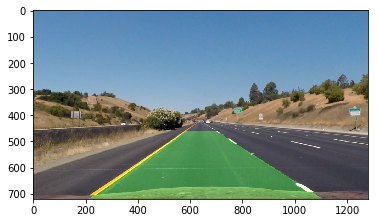

In [28]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
#newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
newwarp = unwarp_image(color_warp)
# Combine the result with the original image
result = cv2.addWeighted(test_img2, 1, newwarp, 0.3, 0)
plt.imshow(result)

## Cleaning up Pipeline

In [41]:
def calibrate_camera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #cv2.imshow('img',img)
            new_fname = fname.replace('camera_cal','camera_cal_with_corners')
            cv2.imwrite(new_fname, img)
            #cv2.waitKey(500)
        #else:
        #    print('No corners found for', fname)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

# Assumes Camera Calibration has already been done
def pipeline(img):
    ## undistort, threshold and warp (perspective transform) image
    undist_img = undistort_image(img, _mtx, _dist)
    thresh_img = threshold(undist_img)
    warped_img = warp_image(thresh_img)
    
    ## calculate and visualize polyfit of lane lines
    left_fit, right_fit, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty = get_lane_line_info(warped_img)

    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Calculate radius of curvature
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print('Radius of Curvature:', left_curverad, 'm', right_curverad, 'm')
    left_lane_pos = left_fitx[0]*xm_per_pix
    #print(left_lane_pos)
    right_lane_pos = right_fitx[0]*xm_per_pix
    #print(right_lane_pos)
    center_lane_pos = left_lane_pos + (3.7/2)
    img_center = (img.shape[1]*xm_per_pix)/2
    center_offset = round(center_lane_pos - img_center, 2)
    
    vehicle_center_msg = ''
    if center_offset < 0:
        vehicle_center_msg = 'Vehicle is ' + str(abs(center_offset)) + ' meters right of center'
    elif center_offset > 0:
        vehicle_center_msg = 'Vehicle is ' + str(abs(center_offset)) + ' meters left of center'
    else:
        vehicle_center_msg = 'Vehicle is at center'
        
    radius_of_curvature_msg = 'Radius of Curvature: ' + str(round(left_curverad)) + ' m (left), ' + str(round(right_curverad)) + ' m (right)'
    
    #print(radius_of_curvature_msg)
    #print(vehicle_center_msg)
        
    ## Draw lane position back onto unwarped road image
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    #newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    newwarp = unwarp_image(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    # Write radius of curvature and center offset on image
    font = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText1 = (45,45)
    bottomLeftCornerOfText2 = (45,90)
    fontScale = 1
    fontColor = (255,255,255)
    lineType = 2

    cv2.putText(result, radius_of_curvature_msg, 
        bottomLeftCornerOfText1, 
        font, 
        fontScale,
        fontColor,
        lineType)
    
    cv2.putText(result, vehicle_center_msg, 
        bottomLeftCornerOfText2, 
        font, 
        fontScale,
        fontColor,
        lineType)
    
    #plt.title(radius_of_curvature_msg + '\n' + vehicle_center_msg)
    #plt.imshow(result)
    
    # return lane lines
    left_lane = Line()
    # was the line detected in the last iteration?
    left_lane.detected = True  
    # x values of the last n fits of the line
    left_lane.recent_xfitted = [] 
    #average x values of the fitted line over the last n iterations
    left_lane.bestx = None     
    #polynomial coefficients averaged over the last n iterations
    left_lane.best_fit = None  
    #polynomial coefficients for the most recent fit
    left_lane.current_fit = [np.array([False])]  
    left_lane.radius_of_curvature = left_curverad
    left_lane.line_base_pos = img_center - left_lane_pos
    #difference in fit coefficients between last and new fits
    left_lane.diffs = np.array([0,0,0], dtype='float') 
    left_lane.allx = leftx  
    left_lane.ally = lefty
    
    right_lane = Line()
    # was the line detected in the last iteration?
    right_lane.detected = True  
    # x values of the last n fits of the line
    right_lane.recent_xfitted = [] 
    #average x values of the fitted line over the last n iterations
    right_lane.bestx = None     
    #polynomial coefficients averaged over the last n iterations
    right_lane.best_fit = None  
    #polynomial coefficients for the most recent fit
    right_lane.current_fit = [np.array([False])]  
    right_lane.radius_of_curvature = right_curverad
    right_lane.line_base_pos = right_lane_pos - img_center
    #difference in fit coefficients between last and new fits
    right_lane.diffs = np.array([0,0,0], dtype='float') 
    right_lane.allx = rightx  
    right_lane.ally = righty
    
    return result#left_lane, right_lane
    
    

In [30]:
# Calibrate Camera
_ret, _mtx, _dist, _rvecs, _tvecs = calibrate_camera()
#img = cv2.imread('camera_cal/calibration1.jpg')
#undist_img = undistort_image(img, mtx, dist)
#cv2.imshow('img', undist_img)

In [42]:
# Run single image thru pipeline
test_pipeline_img = mpimg.imread('test_images/test2.jpg')
#test_pipeline_img = mpimg.imread('test_images/straight_lines2.jpg')
#left_lane, right_lane = pipeline(test_pipeline_img)
out_img = pipeline(test_pipeline_img)

In [43]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [44]:
video_output = 'test_videos_output/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(20,25)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4


100%|█████████▉| 1260/1261 [03:04<00:00,  7.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output.mp4 

CPU times: user 6min 34s, sys: 14.7 s, total: 6min 48s
Wall time: 3min 6s


In [45]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))